In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

cm = 1/2.54
fontsize = 10


def plot_heatmap(data, metrics, use_annot=True, sort_by='internal_energy', save_file="Fig2a_PB_Heatmap_v2.pdf"):
    """
    Plots a heatmap where rows are models and columns are metrics,
    sorted by a specific metric (e.g., internal_energy).
    """
    factor_labels = {
        'internal_energy': 'Internal Energy',
        'minimum_distance_to_protein': 'Protein Min. Distance',
        'protein-ligand_maximum_distance': 'Protein-Ligand Max. Distance',
        'internal_steric_clash': 'Internal Steric Clash',
        'bond_lengths': 'Bond Lengths',
        'bond_angles': 'Bond Angles',
        'aromatic_ring_flatness': 'Aromatic Ring Flatness',
        'double_bond_flatness': 'Double Bond Flatness',
        'volume_overlap_with_protein': 'Protein Volume Overlap',
        'PBvalid_pass_all': 'PB Valid',
    }

    df_denovo = pd.DataFrame(index=[factor_labels[m] for m in metrics])
    for model_name, model_data in data["De novo"].items():
        df_denovo[model_name] = [model_data.get(m, np.nan) for m in metrics]
    
    df_denovo = df_denovo.loc[:, df_denovo.loc[sort_by].sort_values(ascending=False).index]

    df_hit2lead = pd.DataFrame(index=[factor_labels[m] for m in metrics])
    for model_name, model_data in data["Hit to Lead"].items():
        df_hit2lead[model_name] = [model_data.get(m, np.nan) for m in metrics]
    
    df_hit2lead = df_hit2lead.loc[:, df_hit2lead.loc[sort_by].sort_values(ascending=False).index]

    df_final = pd.concat([df_denovo, df_hit2lead], axis=1)

    plt.figure(figsize=(9,4.5), dpi=300)
    sns.set(font_scale=1.0)

    colors = [
        (0.0, '#d73027'),  
        (0.25, '#fc8d59'), 
        (0.5, '#fee08b'),  
        (1.0, '#1a9850') 
    ]

    cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)
    ax = sns.heatmap(
        df_final,
        annot=use_annot,
        fmt=".3f",
        # cmap="Greens",
        cmap=cmap,
        # vmin=0.3,
        vmin=0.0,
        vmax=1.0,
        linewidths=0.5,
        linecolor="gray",
        annot_kws={"fontsize":fontsize-3.5}   #7
    )

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize-3)

    
    cbar.set_label("Pass Rate",fontdict={'size': fontsize-2})  #8
    ax.tick_params(
        axis='both',        
        which='both',       
        direction='inout', 
        length=4,           
        width=0.8,          
        colors='black',     
        bottom=False, top=True, left=True, right=False  
    )

    ax.xaxis.tick_top()                  
    ax.xaxis.set_label_position('top')   
    plt.xticks(rotation=45, ha='left',rotation_mode='anchor',fontsize=fontsize-2.5)  #7.5
    plt.yticks(fontsize=fontsize-2)  #8
        
    y_line = 1.23    
    y_text = 1.25    
    
    group_map =  {
        'De novo': list(data['De novo'].keys()),
        'Hit to Lead': list(data['Hit to Lead'].keys())
    }
    
    for label, model_names in group_map.items():
        
        idxs = [list(df_final.columns).index(name) for name in model_names if name in df_final.columns]
        
        if label == 'De novo':
            x_start = min(idxs) + 0.5
            x_end = max(idxs) + 0.5
        if label == 'Hit to Lead':
            x_start = 9.5
            x_end = 13.5

        x_center = (x_start + x_end) / 2
        
        ax.plot([x_start-0.2, x_end+0.2], [y_line, y_line], 
                color='black', linewidth=0.6, clip_on=False, transform=ax.get_xaxis_transform())
        
        # 写分组名（denovo / hit2lead）
        ax.text(x_center, y_text, label,
                ha='center', va='bottom', fontsize=9,
                clip_on=False, transform=ax.get_xaxis_transform())
    


    plt.tight_layout()
    plt.savefig(save_file, format="svg", bbox_inches='tight')
    plt.show()

## denovo data split into seen and unseen

In [ ]:
import os
import pandas as pd

denovo_all_csv = "./final_plot/posebuster/posebuster_denovo_repeat_all.csv"

df_all = pd.read_csv(denovo_all_csv)
df_seen = df_all[~df_all['UniprotID'].isin(unseen_uniprot)]
df_unseen = df_all[df_all['UniprotID'].isin(unseen_uniprot)]

df_seen.to_csv(os.path.join(os.path.dirname(denovo_all_csv), "posebuster_denovo_repeat_seen.csv"), index=False)
df_unseen.to_csv(os.path.join(os.path.dirname(denovo_all_csv), "posebuster_denovo_repeat_unseen.csv"), index=False)


## hit2lead data split into seen unseen

In [ ]:
import os
import pandas as pd

hit2lead_all_csv = "./final_plot/posebuster/posebuster_hit2lead_repeat_all.csv"

df_all = pd.read_csv(hit2lead_all_csv)
df_seen = df_all[~df_all['UniprotID'].isin(unseen_uniprot)]
df_unseen = df_all[df_all['UniprotID'].isin(unseen_uniprot)]

df_seen.to_csv(os.path.join(os.path.dirname(hit2lead_all_csv), "posebuster_hit2lead_repeat_seen.csv"), index=False)
df_unseen.to_csv(os.path.join(os.path.dirname(hit2lead_all_csv), "posebuster_hit2lead_repeat_unseen.csv"), index=False)


/tmp/ipykernel_789901/2516482710.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(hit2lead_all_csv)


# data process

## denovo

In [ ]:
import os
import pandas as pd

filter_keys = [
    "mol_pred_loaded",
    "sanitization",
    "inchi_convertible",
    "all_atoms_connected",
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    "protein-ligand_maximum_distance",
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "minimum_distance_to_waters",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
    "volume_overlap_with_waters",
    "PBvalid_pass_all"
]

df_all = pd.read_csv("./final_plot/posebuster/posebuster_denovo_repeat_all.csv")
df_seen = pd.read_csv("./final_plot/posebuster/posebuster_denovo_repeat_seen.csv")
df_unseen = pd.read_csv("./final_plot/posebuster/posebuster_denovo_repeat_unseen.csv")


# filter all_atoms_connected

df_all = df_all[df_all['all_atoms_connected'] == True]
df_seen = df_seen[df_seen['all_atoms_connected'] == True]
df_unseen = df_unseen[df_unseen['all_atoms_connected'] == True]

df_all_grouped = df_all.groupby(["Model", "round"], as_index=False)[filter_keys].sum()
df_seen_grouped = df_seen.groupby(["Model", "round"], as_index=False)[filter_keys].sum()
df_unseen_grouped = df_unseen.groupby(["Model", "round"], as_index=False)[filter_keys].sum()

df_all_mean = df_all_grouped.groupby("Model", as_index=False)[filter_keys].mean()
df_seen_mean = df_seen_grouped.groupby("Model", as_index=False)[filter_keys].mean()
df_unseen_mean = df_unseen_grouped.groupby("Model", as_index=False)[filter_keys].mean()

df_all_mean[filter_keys] = df_all_mean[filter_keys] / 120000 
df_seen_mean[filter_keys] = df_seen_mean[filter_keys] / 85000
df_unseen_mean[filter_keys] = df_unseen_mean[filter_keys] / 35000


df_all_mean.to_csv(os.path.join("./selfGenBench/final_plot/posebuster", "posebuster_denovo_summary_all_connected.csv"), index=False)
df_seen_mean.to_csv(os.path.join("./selfGenBench/final_plot/posebuster", "posebuster_denovo_summary_seen_connected.csv"), index=False)
df_unseen_mean.to_csv(os.path.join("./selfGenBench/final_plot/posebuster", "posebuster_denovo_summary_unseen_connected.csv"), index=False)

## hit2lead

In [ ]:
import os
import pandas as pd


filter_keys = [
    "mol_pred_loaded",
    "sanitization",
    "inchi_convertible",
    "all_atoms_connected",
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    "protein-ligand_maximum_distance",
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "minimum_distance_to_waters",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
    "volume_overlap_with_waters",
    "PBvalid_pass_all"
]


df_all = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_repeat_all.csv")
df_seen = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_repeat_seen.csv")
df_unseen = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_repeat_unseen.csv")

def fix_df(df):
    df[filter_keys] = df[filter_keys].replace({'True': True, 'False': False})
    df[filter_keys] = df[filter_keys].astype(float)   
    df[filter_keys] = df[filter_keys].fillna(0).astype(int)
    return df


df_all = fix_df(df_all)
df_seen = fix_df(df_seen)
df_unseen = fix_df(df_unseen)

# filter all_atoms_connected
df_all = df_all[df_all['all_atoms_connected'] == True]
df_seen = df_seen[df_seen['all_atoms_connected'] == True]
df_unseen = df_unseen[df_unseen['all_atoms_connected'] == True]

df_all_grouped = df_all.groupby(["Model", "round"], as_index=False)[filter_keys].sum()
df_seen_grouped = df_seen.groupby(["Model", "round"], as_index=False)[filter_keys].sum()
df_unseen_grouped = df_unseen.groupby(["Model", "round"], as_index=False)[filter_keys].sum()

df_all_mean = df_all_grouped.groupby("Model", as_index=False)[filter_keys].mean()
df_seen_mean = df_seen_grouped.groupby("Model", as_index=False)[filter_keys].mean()
df_unseen_mean = df_unseen_grouped.groupby("Model", as_index=False)[filter_keys].mean()


df_all_mean[filter_keys] = df_all_mean[filter_keys] / 120000
df_seen_mean[filter_keys] = df_seen_mean[filter_keys] / 85000
df_unseen_mean[filter_keys] = df_unseen_mean[filter_keys] / 35000

df_all_mean.to_csv(os.path.join("./final_plot/posebuster", "posebuster_hit2lead_summary_all_connected.csv"), index=False)
df_seen_mean.to_csv(os.path.join("./final_plot/posebuster", "posebuster_hit2lead_summary_seen_connected.csv"), index=False)
df_unseen_mean.to_csv(os.path.join("./final_plot/posebuster", "posebuster_hit2lead_summary_unseen_connected.csv"), index=False)


/tmp/ipykernel_1663335/1675084515.py:29: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("/home/datahouse1/fanzhehuan/myprojects/selfGenBench/final_plot/posebuster/posebuster_hit2lead_repeat_all.csv")


# plot all atom connected

## all

In [ ]:
import os
import pandas as pd

df_denovo = pd.read_csv("./final_plot/posebuster/posebuster_denovo_summary_all_connected.csv").set_index("Model")
df_hit2lead = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_summary_all_connected.csv").set_index("Model")

data_all = {
    "De novo": df_denovo.to_dict(orient='index'),
    "Hit to Lead": df_hit2lead.to_dict(orient='index')
}
data_all["Hit to Lead"].pop("ShapeMol", None)
data_all

{'De novo': {'DecompDiff': {'mol_pred_loaded': 0.59025,
   'sanitization': 0.59025,
   'inchi_convertible': 0.5886333333333333,
   'all_atoms_connected': 0.59025,
   'bond_lengths': 0.5547361111111111,
   'bond_angles': 0.5277416666666667,
   'internal_steric_clash': 0.55415,
   'aromatic_ring_flatness': 0.5899833333333333,
   'double_bond_flatness': 0.5679277777777777,
   'internal_energy': 0.4786638888888889,
   'protein-ligand_maximum_distance': 0.59025,
   'minimum_distance_to_protein': 0.4056277777777778,
   'minimum_distance_to_organic_cofactors': 0.59025,
   'minimum_distance_to_inorganic_cofactors': 0.59025,
   'minimum_distance_to_waters': 0.59025,
   'volume_overlap_with_protein': 0.5787527777777778,
   'volume_overlap_with_organic_cofactors': 0.59025,
   'volume_overlap_with_inorganic_cofactors': 0.59025,
   'volume_overlap_with_waters': 0.59025,
   'PBvalid_pass_all': 0.3184083333333333},
  'FLAG': {'mol_pred_loaded': 0.1372083333333333,
   'sanitization': 0.137208333333333

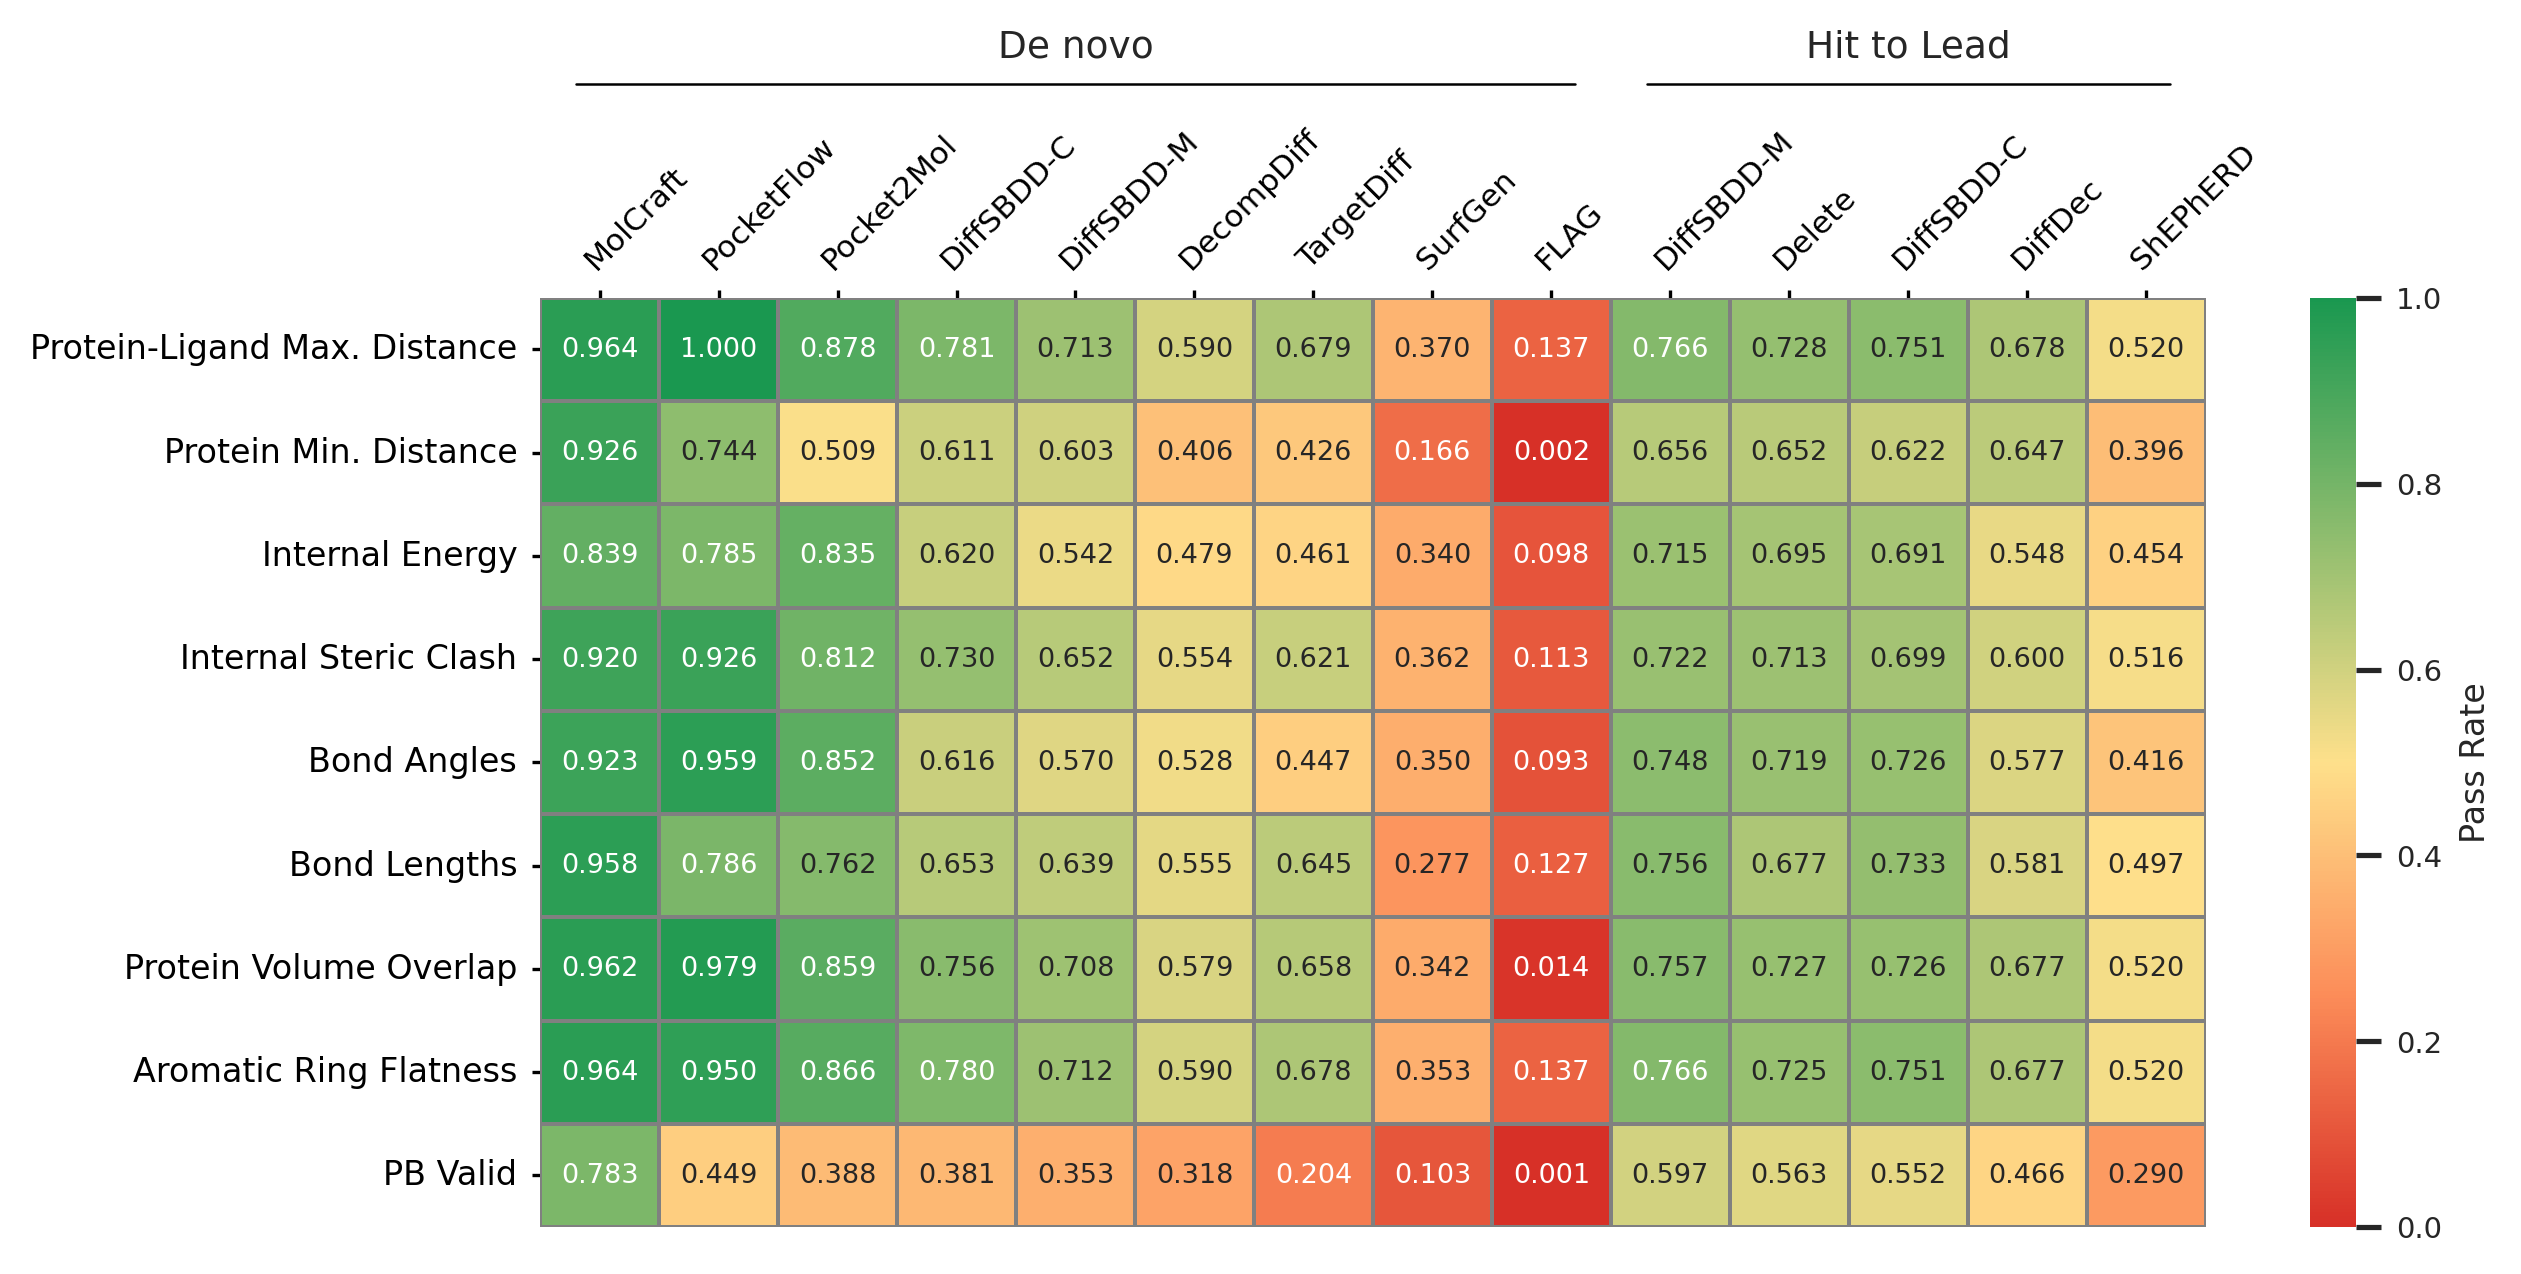

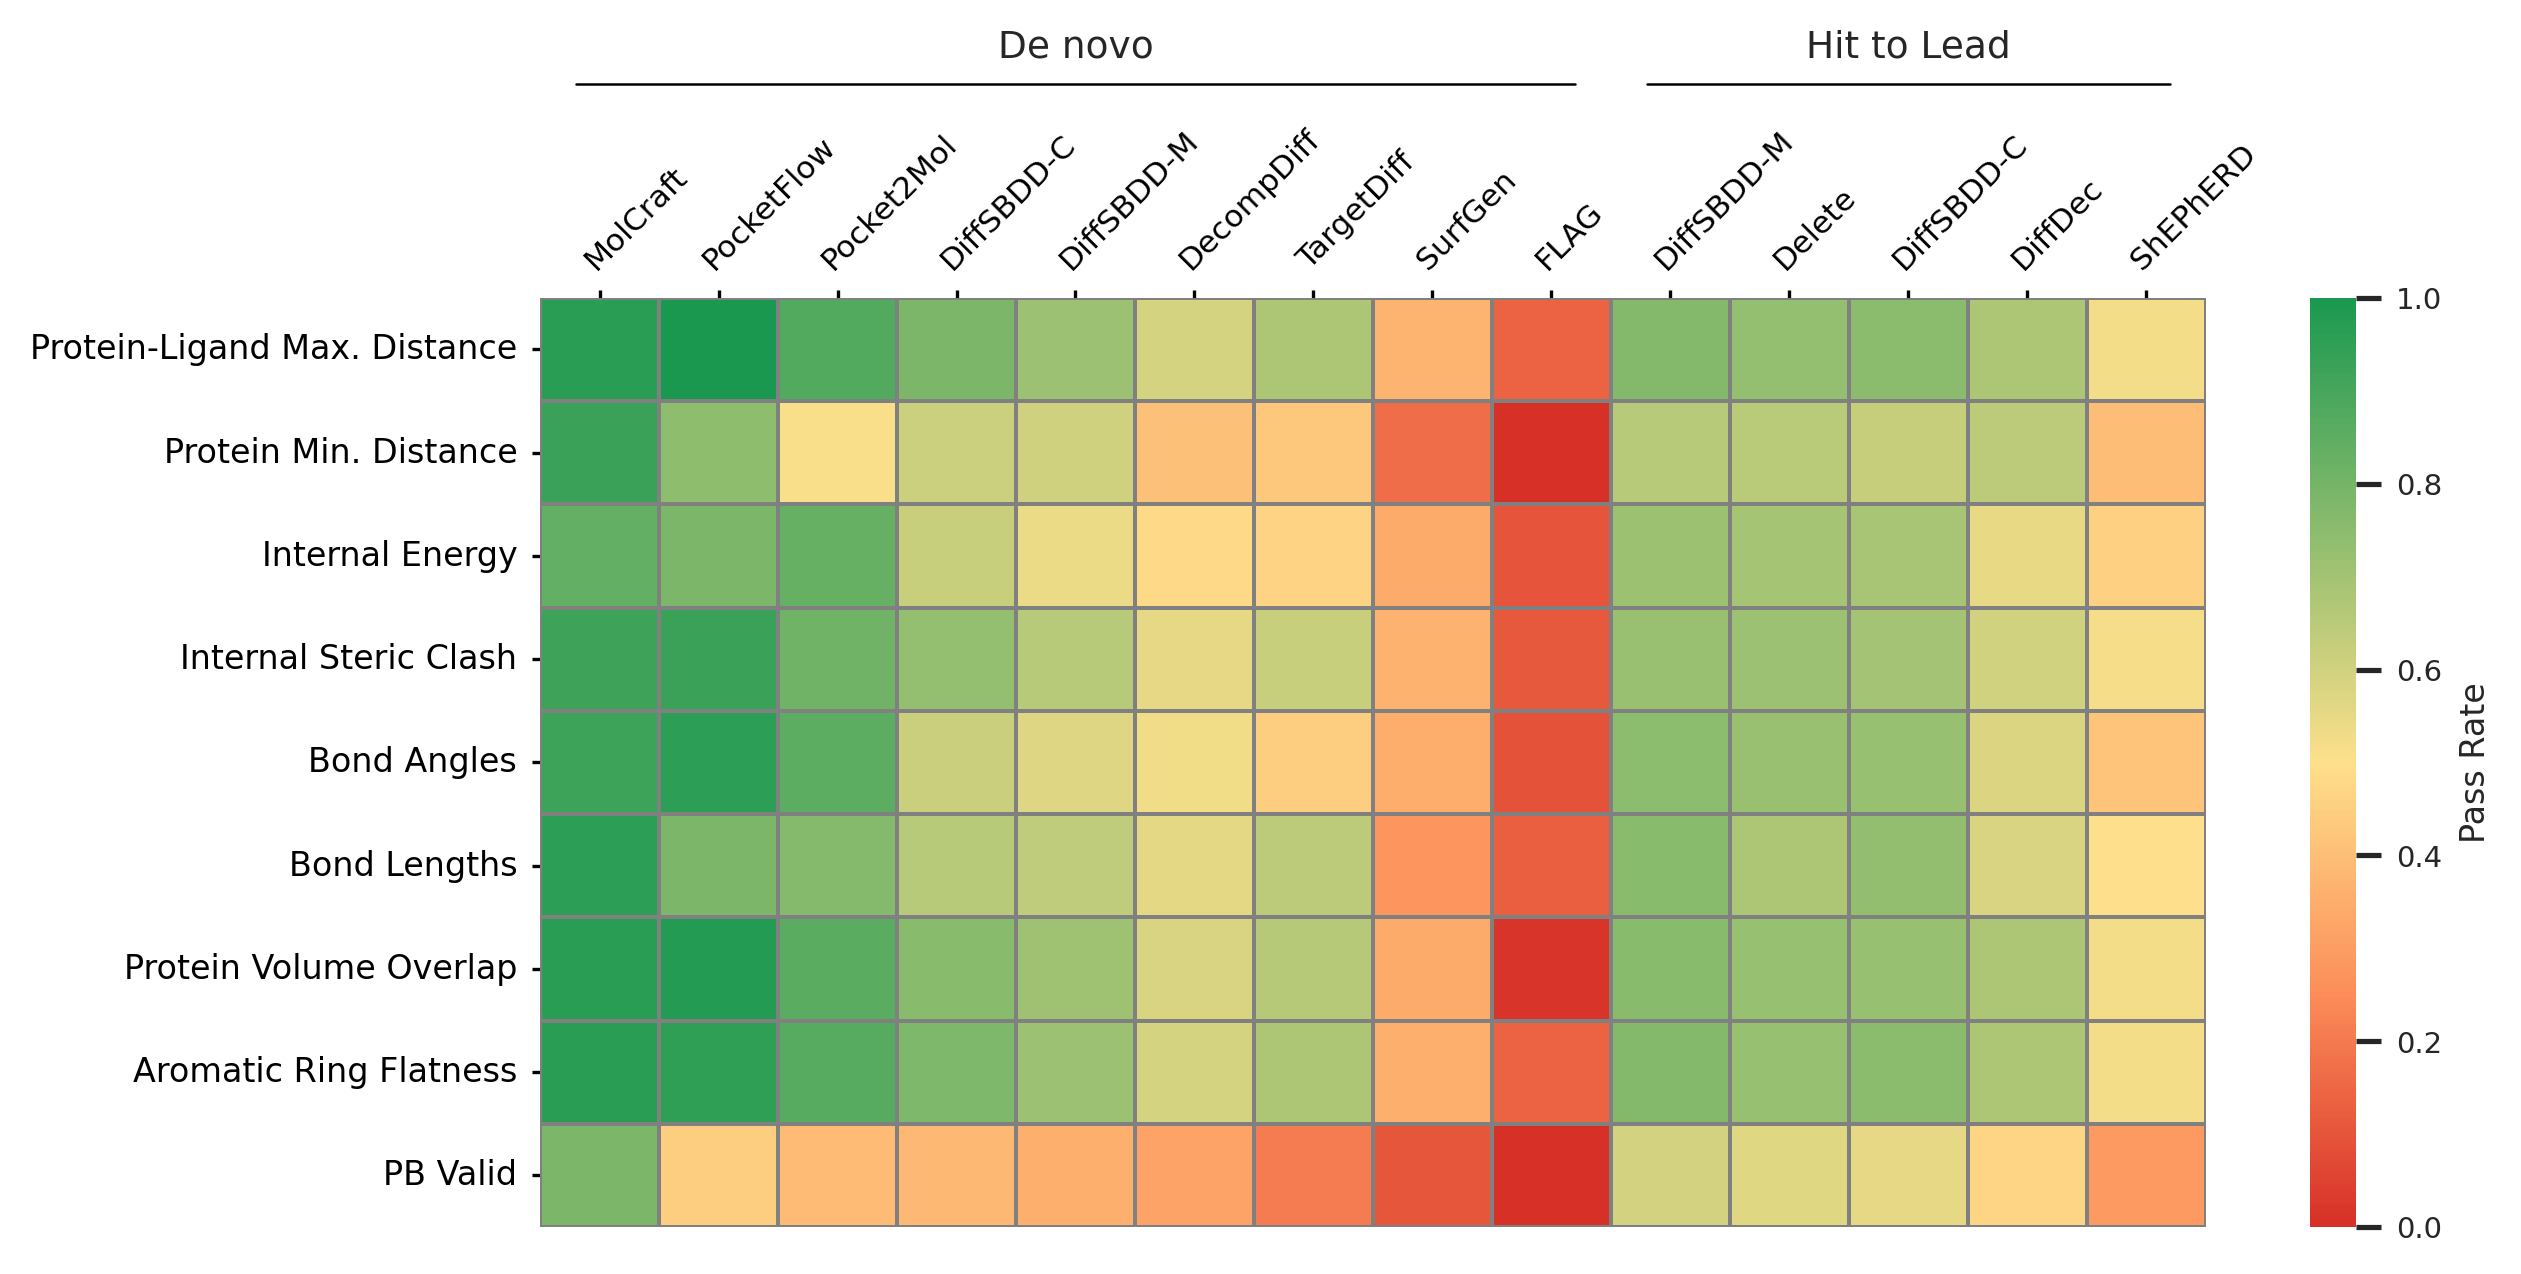

In [ ]:
save_file = "./final_plot/output/02-posebuster_heatmap_all_fixAtomConnect.svg"
save_file_no_annot = "./final_plot/output/02-posebuster_heatmap_all_NoNumber_fixAtomConnect.svg"
top_8_keys = [
    "protein-ligand_maximum_distance",
    'minimum_distance_to_protein',
    'internal_energy',
    'internal_steric_clash',
    'bond_angles',
    'bond_lengths',
    'volume_overlap_with_protein',
    'aromatic_ring_flatness',
    'PBvalid_pass_all',
]
plot_heatmap(data_all, top_8_keys, sort_by='PB Valid', save_file=save_file)
plot_heatmap(data_all, top_8_keys, use_annot=False,sort_by='PB Valid', save_file=save_file_no_annot)


## seen

In [ ]:
import os
import pandas as pd

df_denovo = pd.read_csv("./final_plot/posebuster/posebuster_denovo_summary_seen_connected.csv").set_index("Model")
df_hit2lead = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_summary_seen_connected.csv").set_index("Model")

data_seen = {
    "De novo": df_denovo.to_dict(orient='index'),
    "Hit to Lead": df_hit2lead.to_dict(orient='index')
}
data_seen["Hit to Lead"].pop("ShapeMol", None)
data_seen

{'De novo': {'DecompDiff': {'mol_pred_loaded': 0.5995529411764706,
   'sanitization': 0.5995529411764706,
   'inchi_convertible': 0.597286274509804,
   'all_atoms_connected': 0.5995529411764706,
   'bond_lengths': 0.5636196078431372,
   'bond_angles': 0.5375921568627451,
   'internal_steric_clash': 0.5642392156862746,
   'aromatic_ring_flatness': 0.5993058823529411,
   'double_bond_flatness': 0.5785882352941176,
   'internal_energy': 0.4901686274509804,
   'protein-ligand_maximum_distance': 0.5995529411764706,
   'minimum_distance_to_protein': 0.4048274509803922,
   'minimum_distance_to_organic_cofactors': 0.5995529411764706,
   'minimum_distance_to_inorganic_cofactors': 0.5995529411764706,
   'minimum_distance_to_waters': 0.5995529411764706,
   'volume_overlap_with_protein': 0.5867882352941176,
   'volume_overlap_with_organic_cofactors': 0.5995529411764706,
   'volume_overlap_with_inorganic_cofactors': 0.5995529411764706,
   'volume_overlap_with_waters': 0.5995529411764706,
   'PBvali

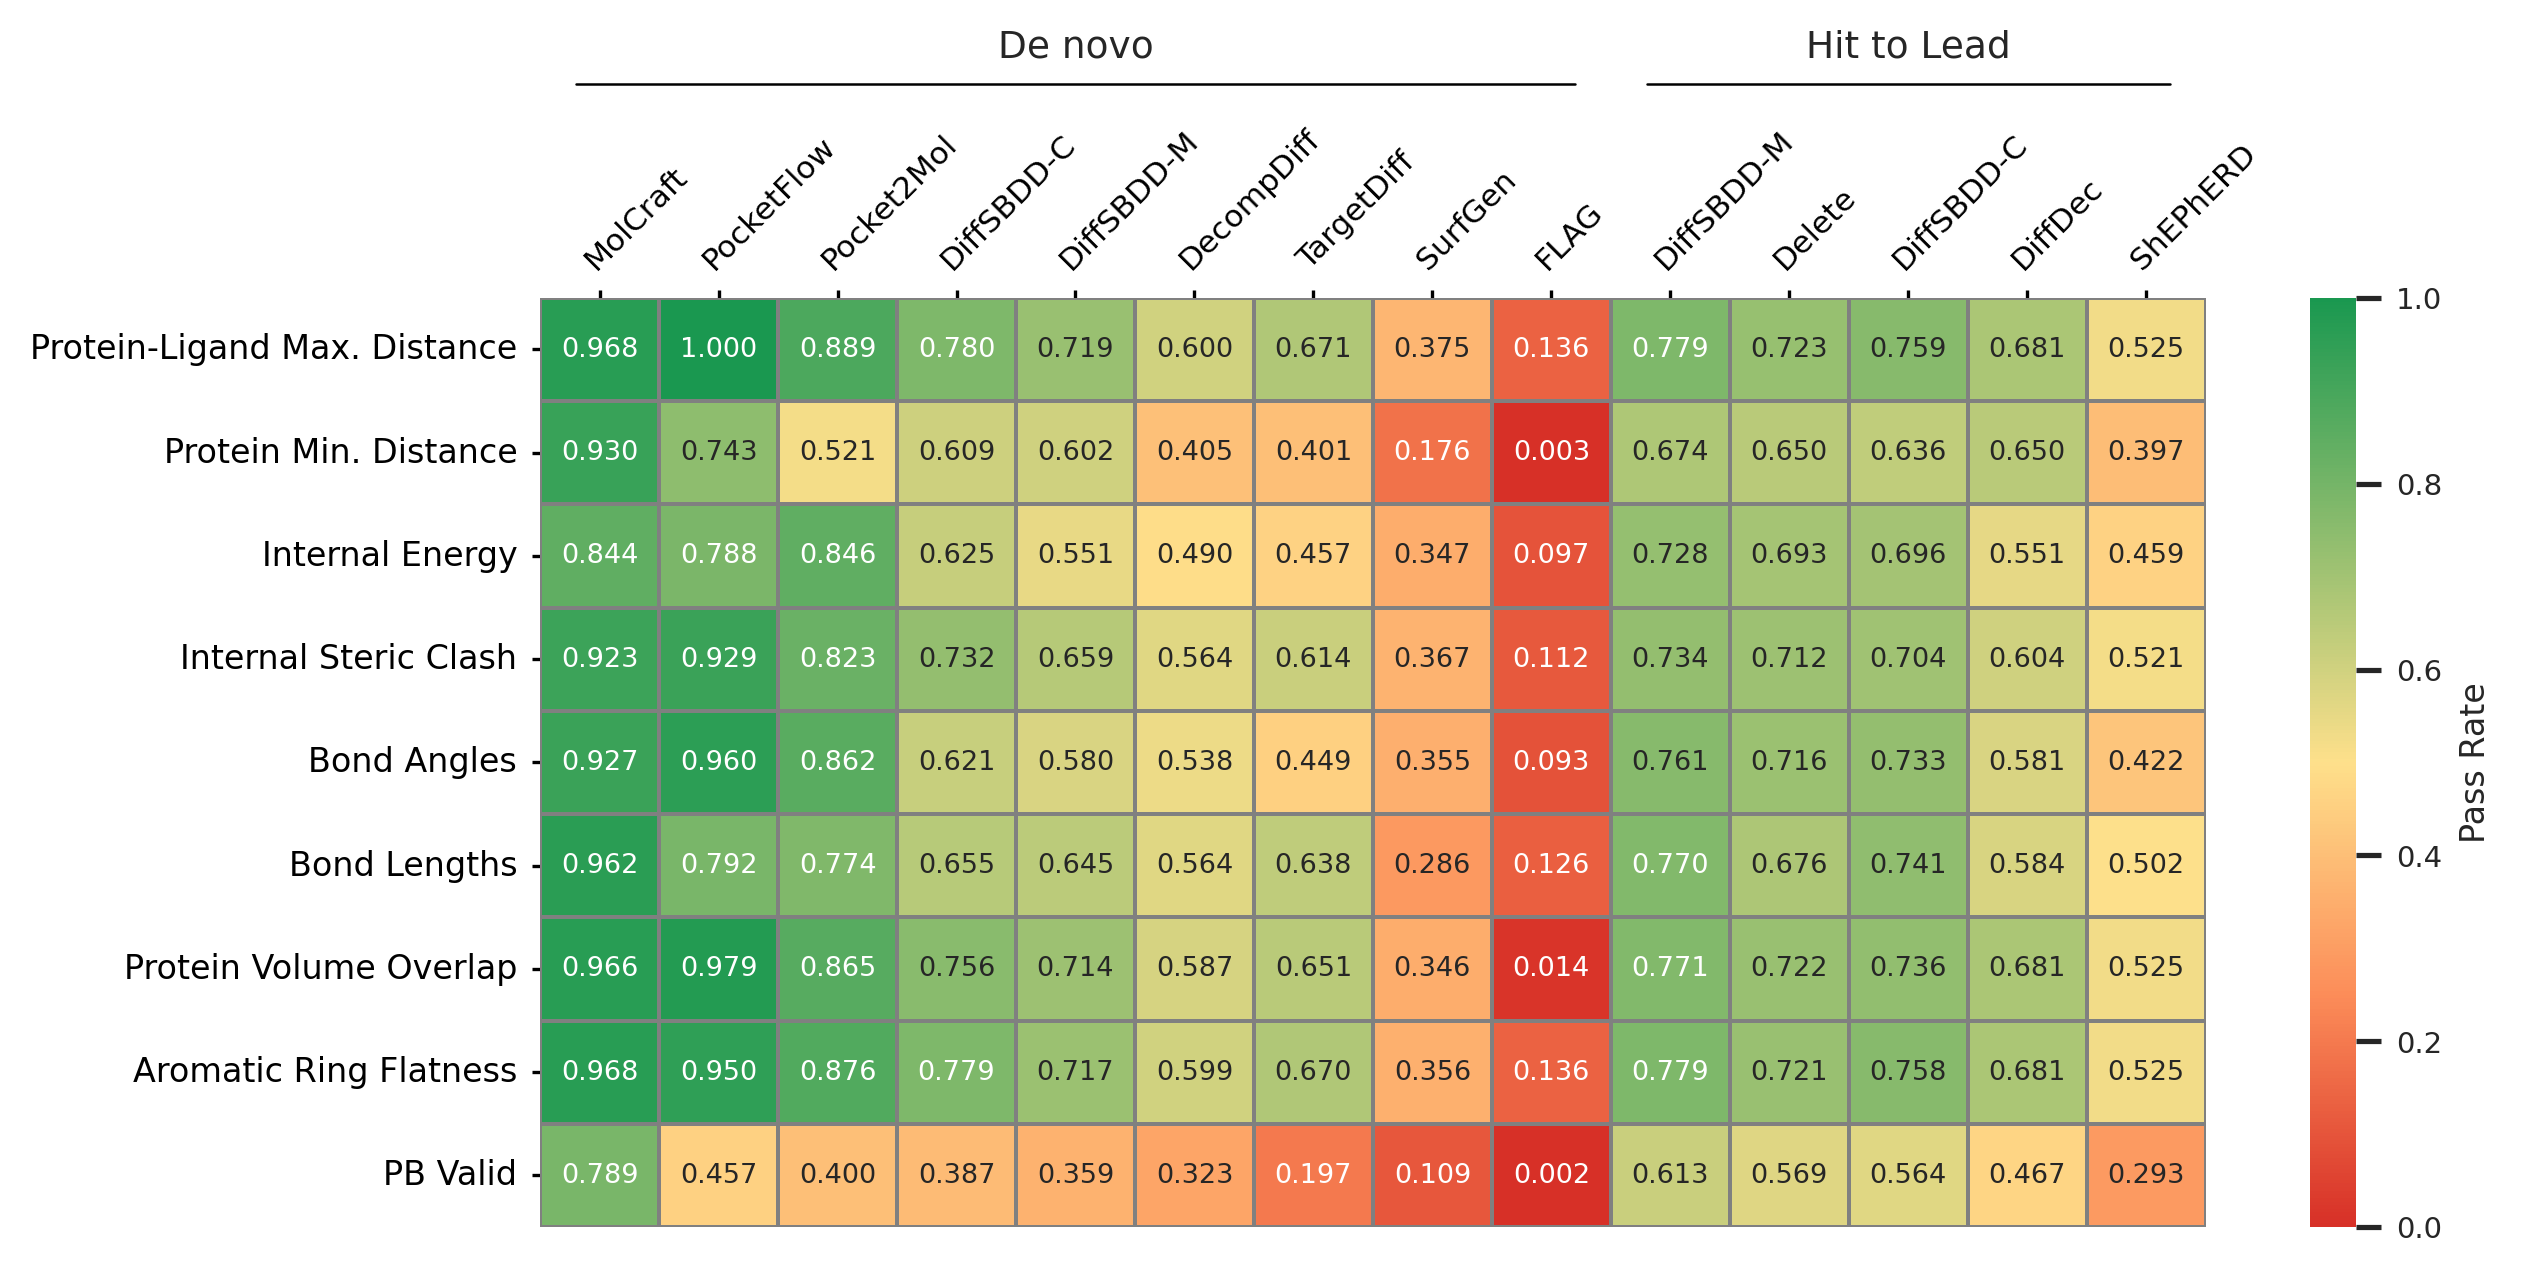

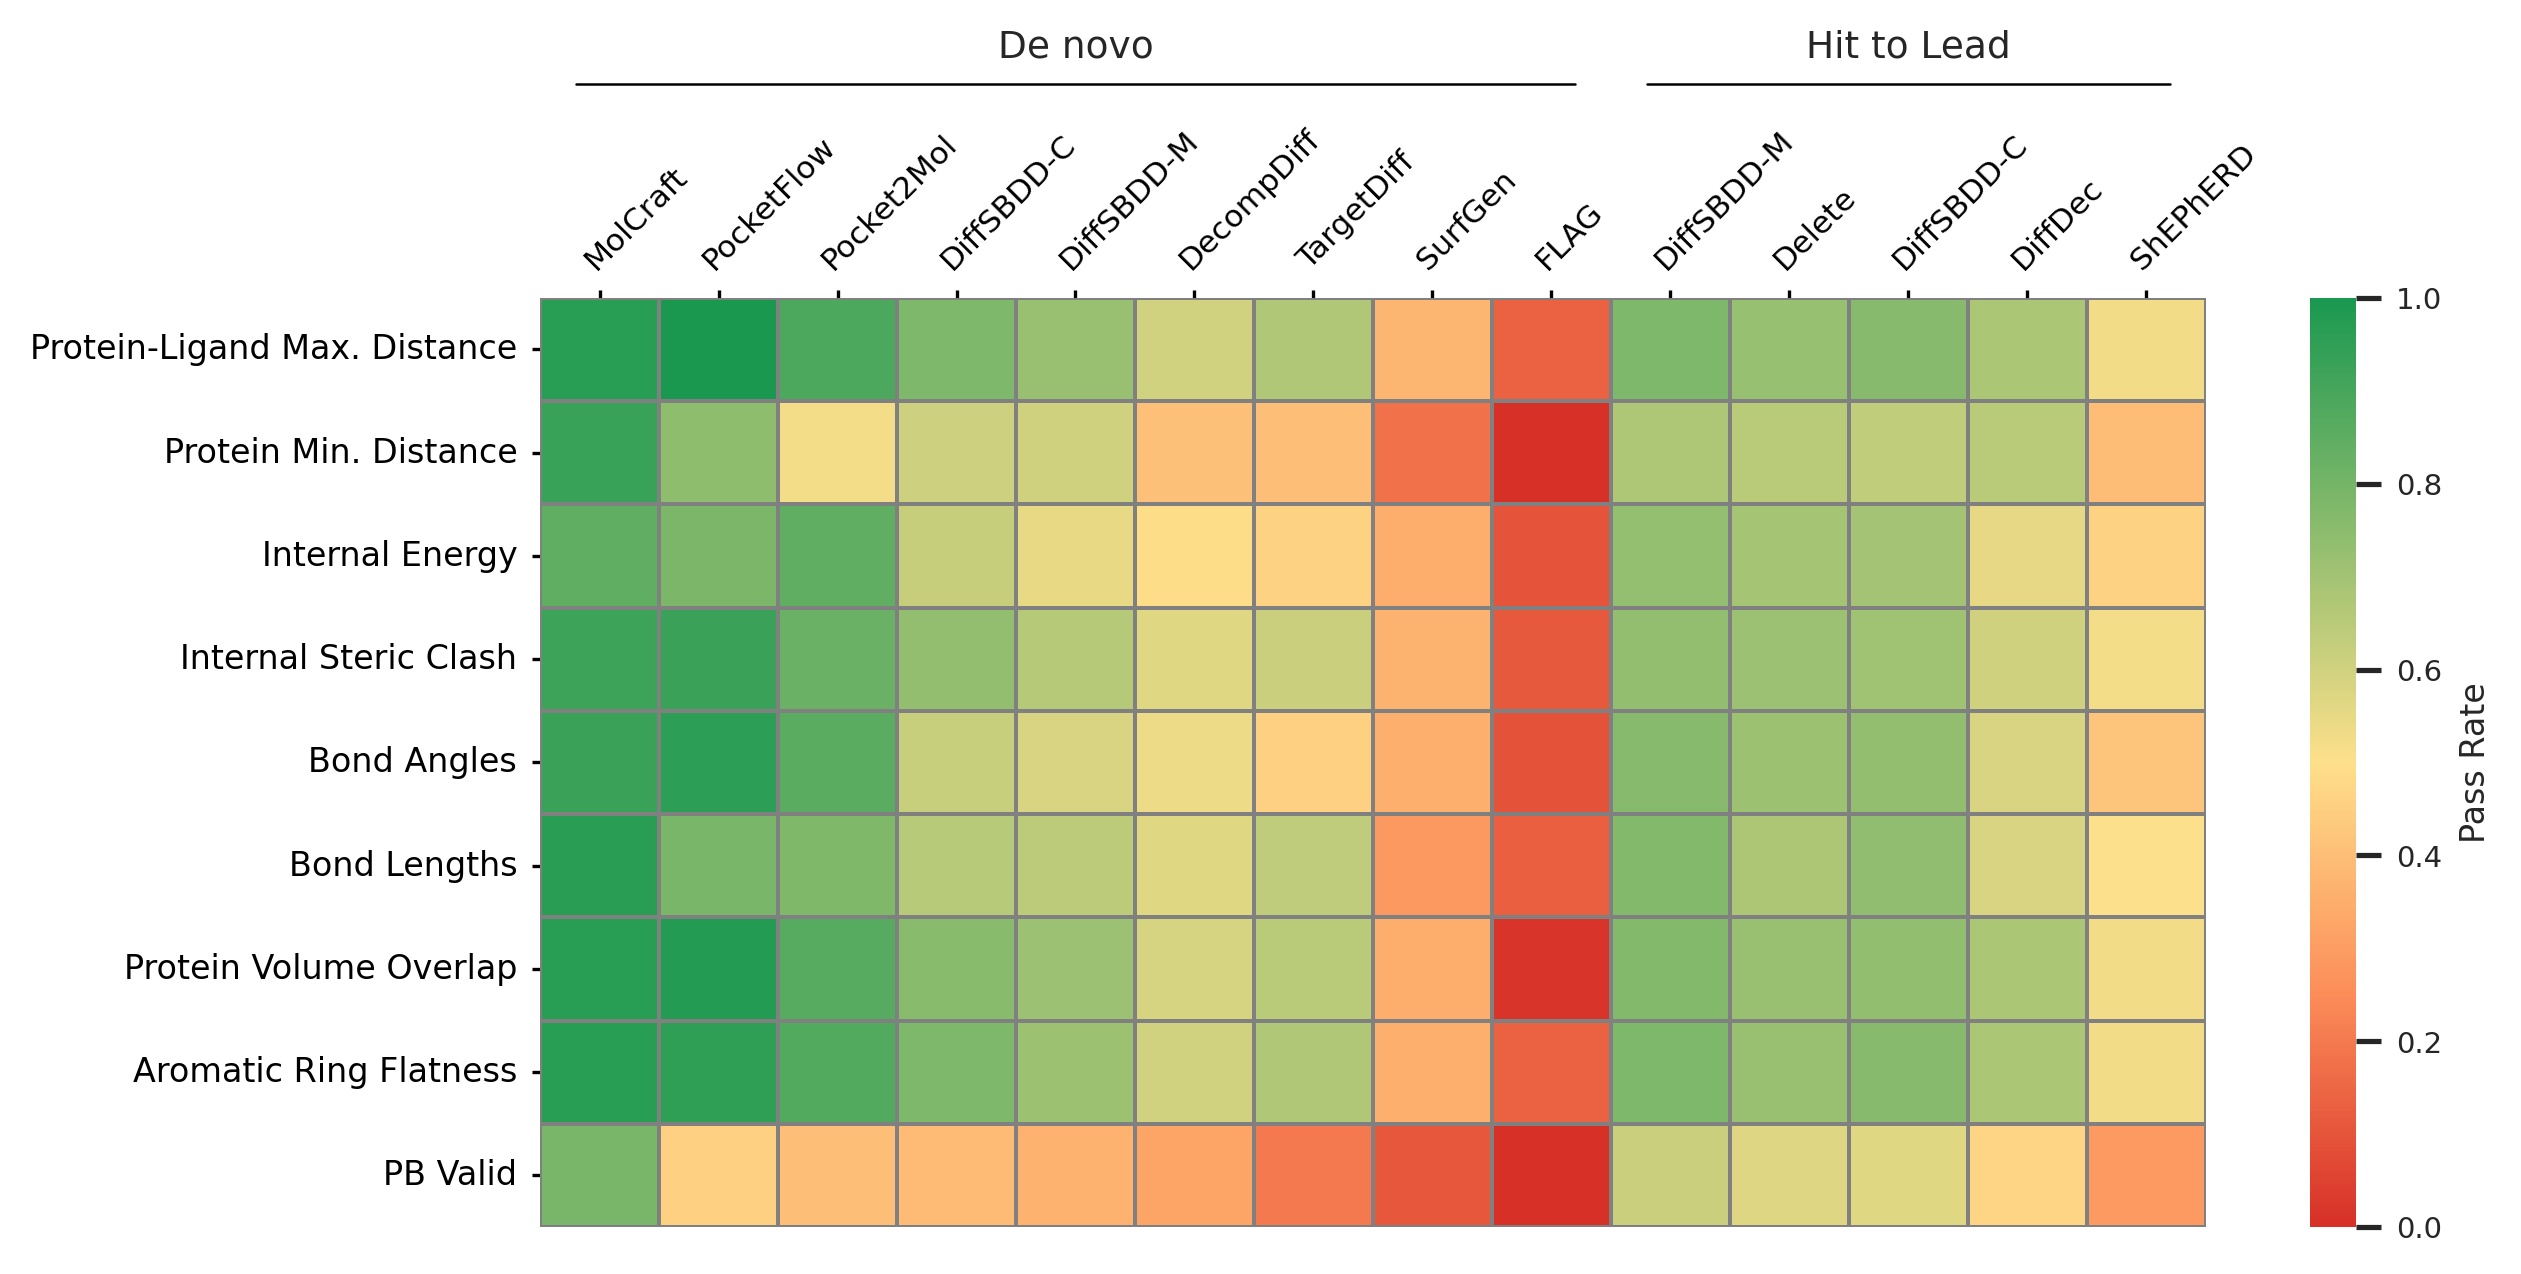

In [ ]:
save_file = "./final_plot/output/02-posebuster_heatmap_seen_fixAtomConnect.svg"
save_file_no_annot = "./final_plot/output/02-posebuster_heatmap_seen_NoNumber_fixAtomConnect.svg"
top_8_keys = [
    "protein-ligand_maximum_distance",
    'minimum_distance_to_protein',
    'internal_energy',
    'internal_steric_clash',
    'bond_angles',
    'bond_lengths',
    'volume_overlap_with_protein',
    # 'non-aromatic_ring_non-flatness',
    'aromatic_ring_flatness',
    'PBvalid_pass_all',
]
plot_heatmap(data_seen, top_8_keys, sort_by='PB Valid', save_file=save_file)
plot_heatmap(data_seen, top_8_keys, use_annot=False,sort_by='PB Valid', save_file=save_file_no_annot)


## unseen

In [ ]:
import os
import pandas as pd

df_denovo = pd.read_csv("./final_plot/posebuster/posebuster_denovo_summary_unseen_connected.csv").set_index("Model")
df_hit2lead = pd.read_csv("./final_plot/posebuster/posebuster_hit2lead_summary_unseen_connected.csv").set_index("Model")

data_unseen = {
    "De novo": df_denovo.to_dict(orient='index'),
    "Hit to Lead": df_hit2lead.to_dict(orient='index')
}
data_unseen["Hit to Lead"].pop("ShapeMol", None)
data_unseen

{'De novo': {'DecompDiff': {'mol_pred_loaded': 0.5676571428571429,
   'sanitization': 0.5676571428571429,
   'inchi_convertible': 0.5676190476190477,
   'all_atoms_connected': 0.5676571428571429,
   'bond_lengths': 0.5331619047619048,
   'bond_angles': 0.5038190476190476,
   'internal_steric_clash': 0.529647619047619,
   'aromatic_ring_flatness': 0.5673428571428571,
   'double_bond_flatness': 0.5420380952380952,
   'internal_energy': 0.4507238095238095,
   'protein-ligand_maximum_distance': 0.5676571428571429,
   'minimum_distance_to_protein': 0.4075714285714286,
   'minimum_distance_to_organic_cofactors': 0.5676571428571429,
   'minimum_distance_to_inorganic_cofactors': 0.5676571428571429,
   'minimum_distance_to_waters': 0.5676571428571429,
   'volume_overlap_with_protein': 0.5592380952380952,
   'volume_overlap_with_organic_cofactors': 0.5676571428571429,
   'volume_overlap_with_inorganic_cofactors': 0.5676571428571429,
   'volume_overlap_with_waters': 0.5676571428571429,
   'PBvali

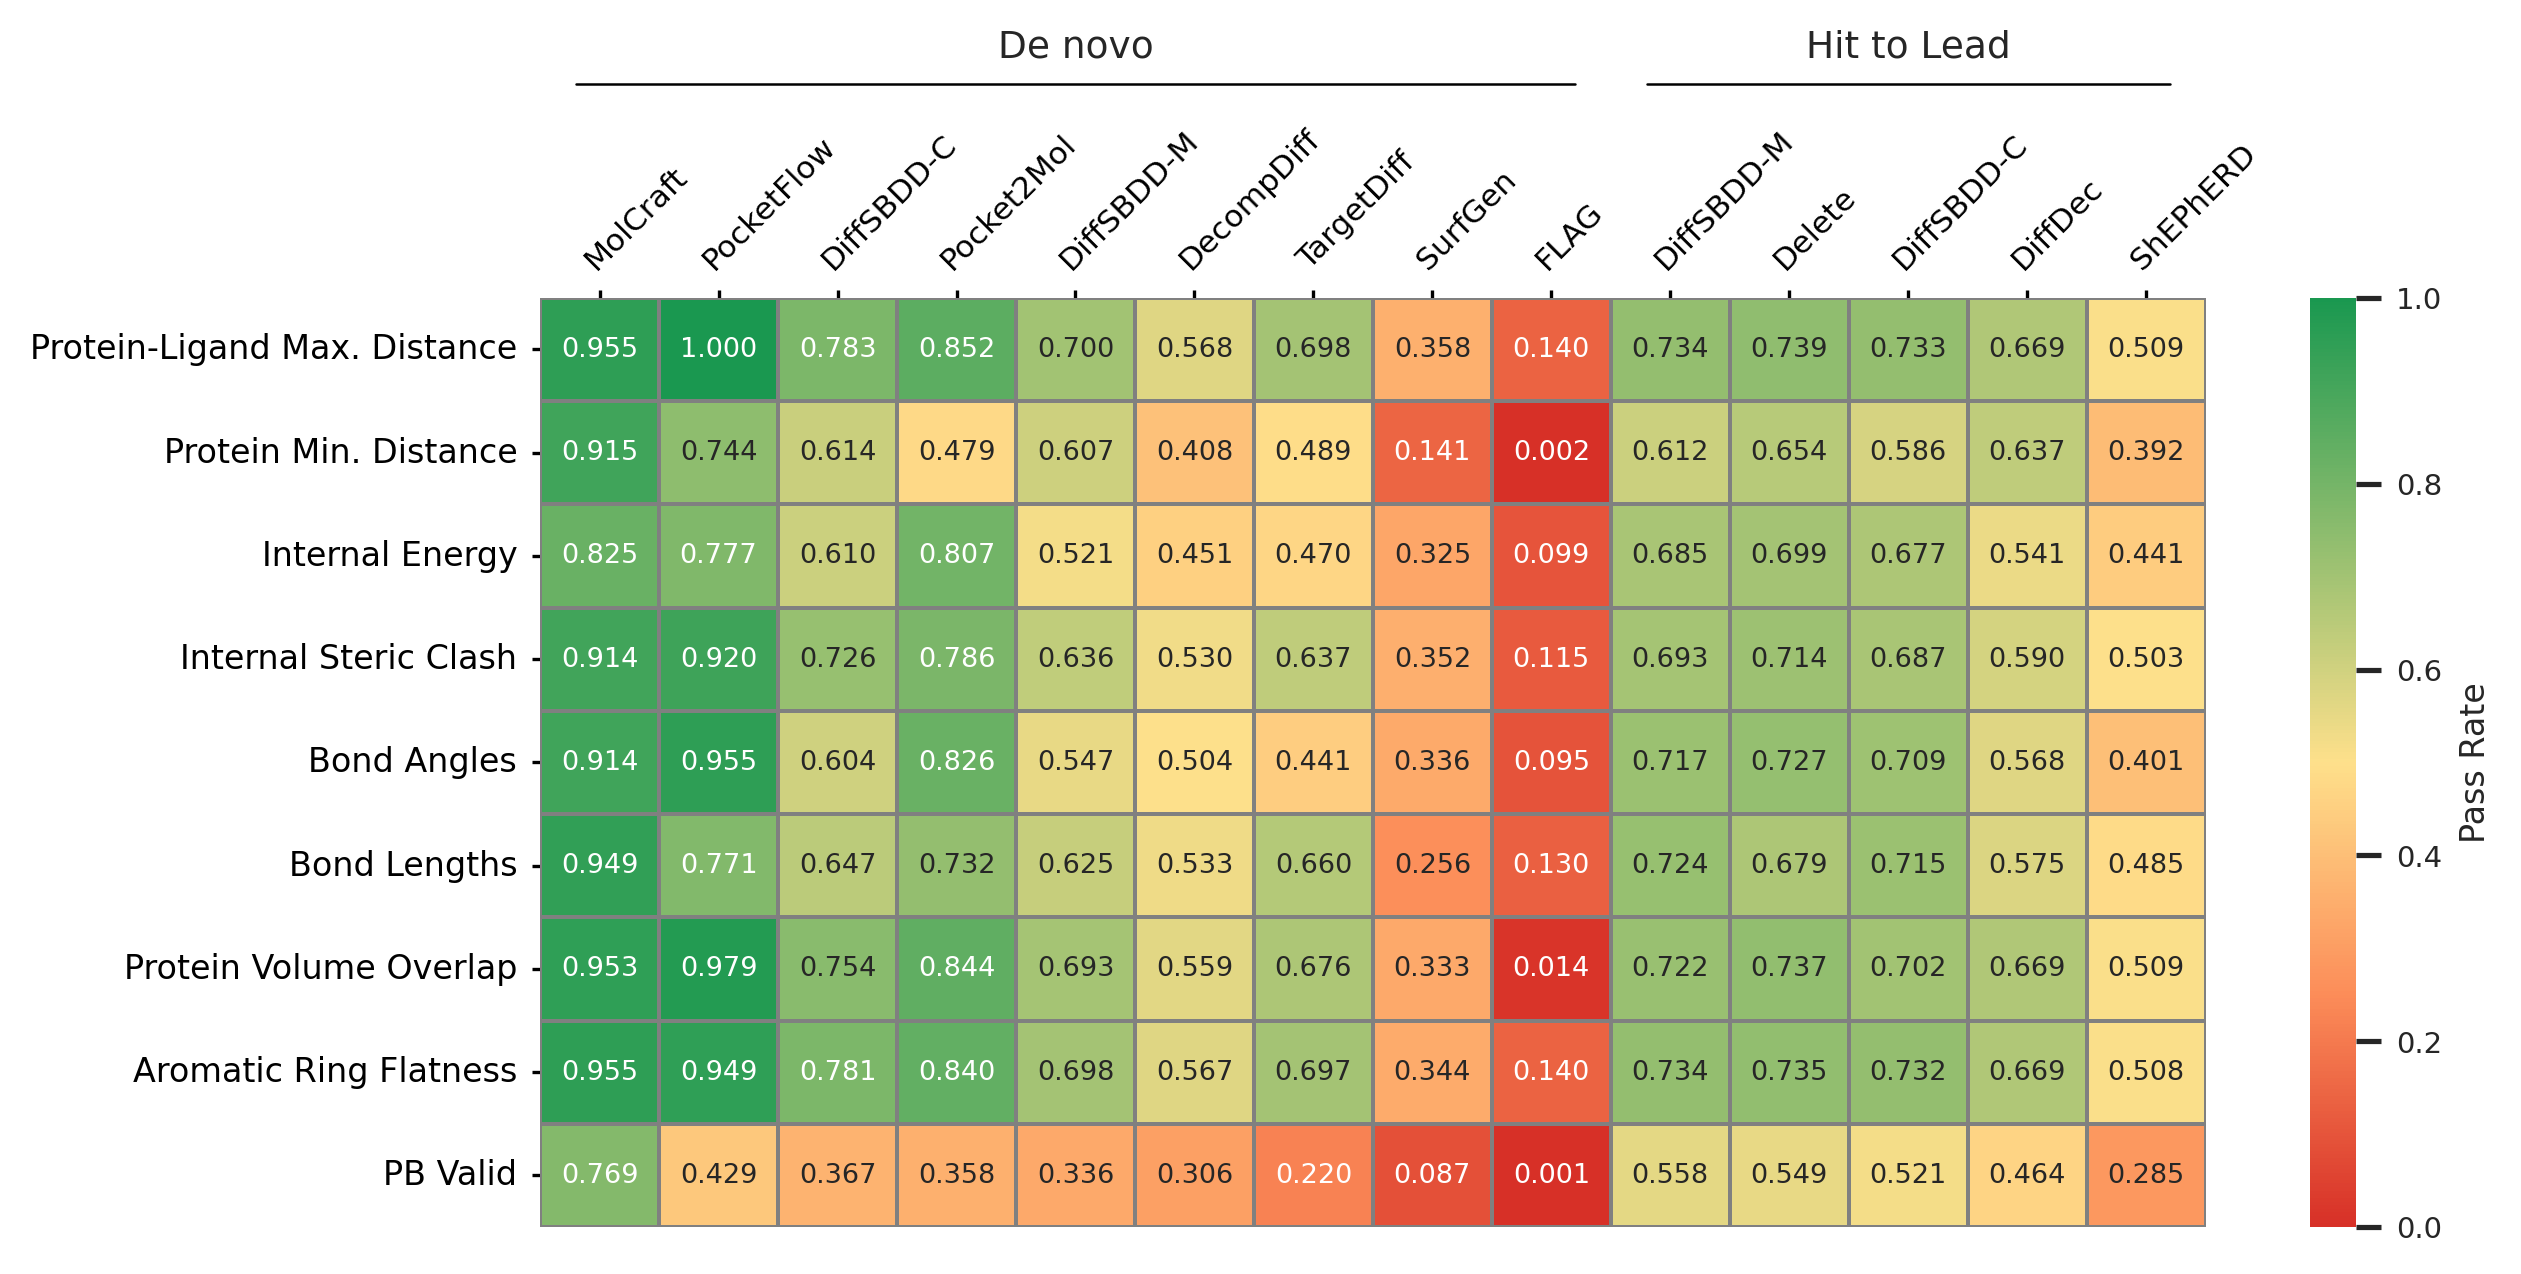

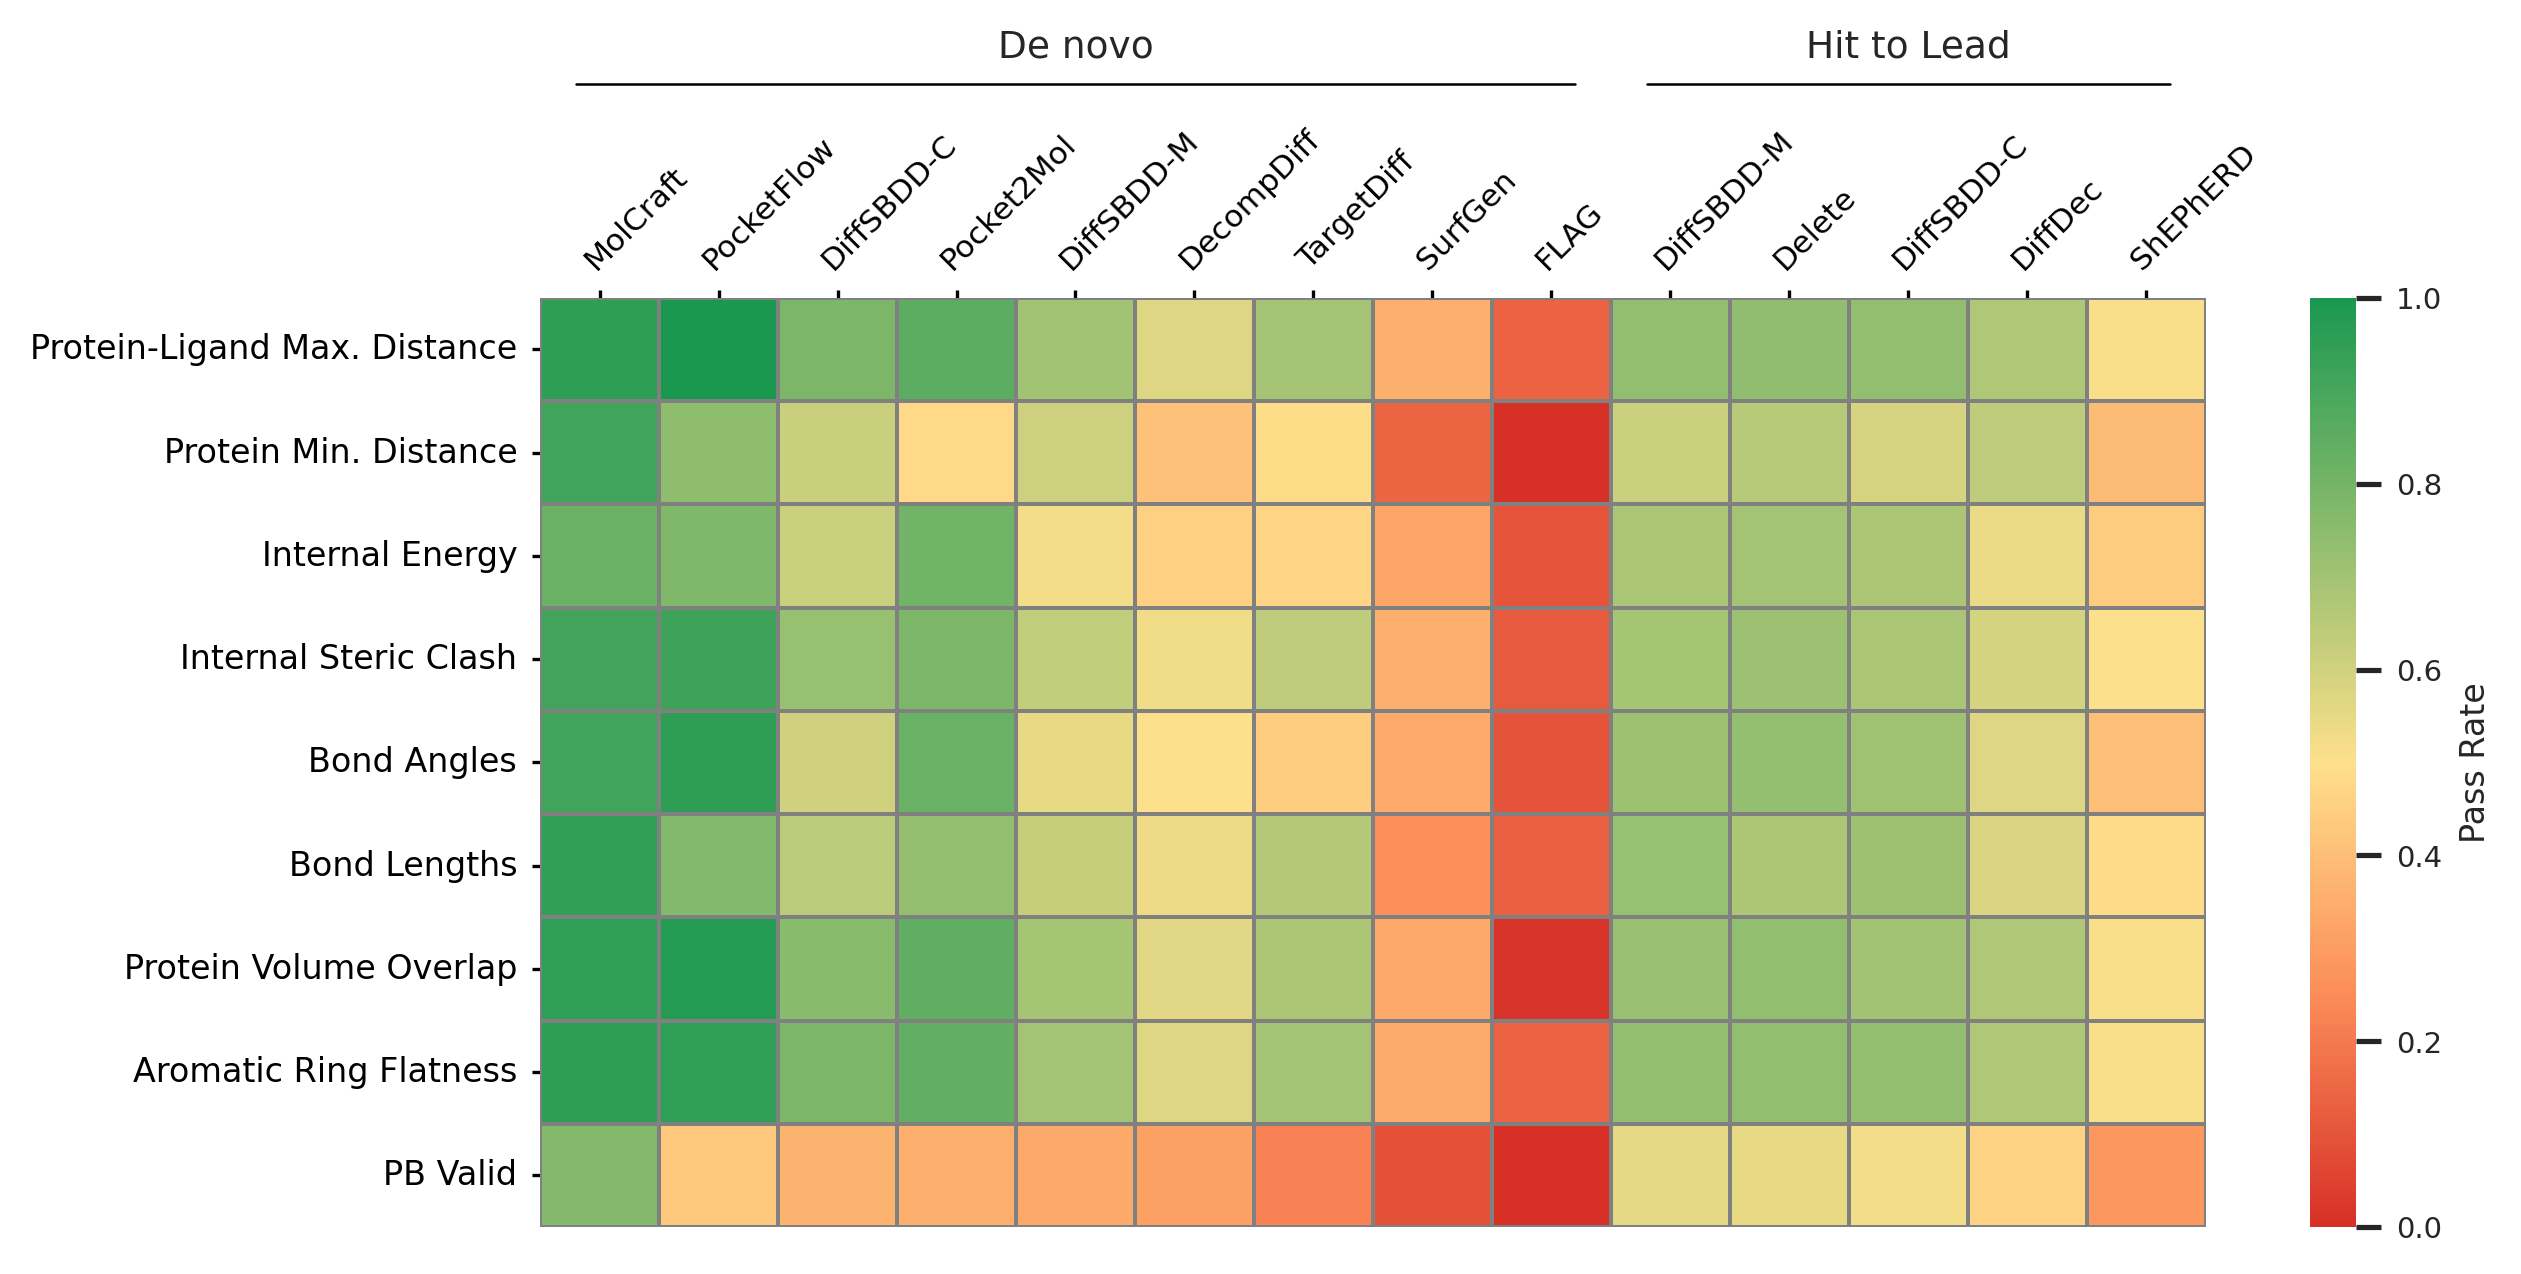

In [36]:
save_file = "/home/datahouse1/fanzhehuan/myprojects/selfGenBench/final_plot/output/02-posebuster_heatmap_unseen_fixAtomConnect.svg"
save_file_no_annot = "/home/datahouse1/fanzhehuan/myprojects/selfGenBench/final_plot/output/02-posebuster_heatmap_unseen_NoNumber_fixAtomConnect.svg"
top_8_keys = [
    "protein-ligand_maximum_distance",
    'minimum_distance_to_protein',
    'internal_energy',
    'internal_steric_clash',
    'bond_angles',
    'bond_lengths',
    'volume_overlap_with_protein',
    # 'non-aromatic_ring_non-flatness',
    'aromatic_ring_flatness',
    'PBvalid_pass_all',
]
plot_heatmap(data_unseen, top_8_keys, sort_by='PB Valid', save_file=save_file)
plot_heatmap(data_unseen, top_8_keys, use_annot=False,sort_by='PB Valid', save_file=save_file_no_annot)
